In [362]:
import scipy as sc
import pandas as pd 
from pprint import pprint
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import functools
import warnings
import tensorflow_probability as tfp
import tensorflow as tf

from src.advi_fcts import * 

tfd = tfp.distributions
tfb = tfp.bijectors

warnings.filterwarnings('ignore')

In [363]:
from src.df_processing import * 

x = pd.read_csv('../taxi+service+trajectory+prediction+challenge+ecml+pkdd+2015/interpolation'+'200'+'.csv')
dataset = extract_traj(x)
reshaped = np.array([i.reshape(-1) for i in dataset])
reshaped.shape
dataset = tf.cast(tf.transpose(tf.convert_to_tensor(reshaped)), tf.float32)

In [364]:
num_datapoints = 195
data_dim = 100
latent_dim = 11

nb_samples = 20
lr = 0.1

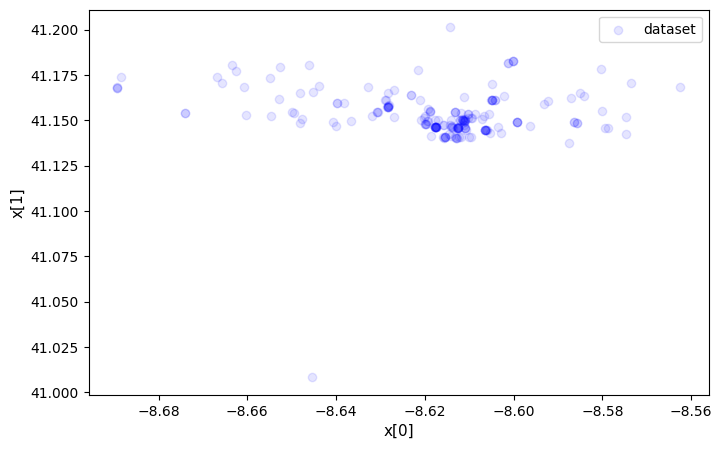

In [365]:
fig = plt.figure(figsize=(8, 5))
plt.scatter(dataset[0, :], dataset[1, :], color='blue', alpha=0.1, label="dataset")
#plt.scatter(x_train[0, :], x_train[1, :], color='magenta', alpha=0.1, label="x_train")
plt.xlabel('x[0]', fontsize=11)
plt.ylabel('x[1]', fontsize=11)
plt.legend()
plt.show()

In [366]:
model = Model(data_dim, latent_dim, num_datapoints, dataset)

advi_model = ADVI_algorithm(data_dim, latent_dim, num_datapoints, dataset, nb_samples, lr )